# Using vectorization to generate features

To train a useful model, we first need to identify relevant features for it to use.

Let's explore the data and try to find patterns and features that could be useful. First, we'll embed our data so we can explore different areas of the vector space.

In [1]:
import pandas as pd
import spacy
import umap
import numpy as np 
from io import BytesIO
from PIL import Image
import base64
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Spectral10, Category10
from pathlib import Path
import sys
sys.path.append("..")
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

from ml_editor.data_processing import format_raw_df, get_split_by_author, get_normalized_series, add_text_features_to_df
from ml_editor.data_visualization import plot_embeddings

df = pd.read_csv(Path('../data/writers.csv'))
df = format_raw_df(df.copy())

train_author, test_author = get_split_by_author(df[df["is_question"]])

questions = train_author[train_author["is_question"]]
raw_text = questions["body_text"]
sent_labels = questions["AcceptedAnswerId"].notna()

# Load a large model, and disable pipeline unnecessary parts for our task
# This speeds up the vectorization process significantly
# See https://spacy.io/models/en#en_core_web_lg for details about the model
nlp = spacy.load('en_core_web_lg', disable=["parser", "tagger", "ner"])

# Get the vector for each of our questions
# By default, the vector returned is the average of all vectors in the sentence
# See https://spacy.io/usage/vectors-similarity for more
spacy_emb = train_author[train_author["is_question"]]["body_text"].apply(lambda x: nlp(x).vector)
embeddings = np.vstack(spacy_emb)

umap_embedder = umap.UMAP()
umap_emb = umap_embedder.fit_transform(embeddings)

## Interactive plot

Next, we use [Bokeh](https://docs.bokeh.org/en/latest/index.html) to explore embeddings interactively.

You can pan left and right, and zoom in to any particular zone of interest. Hover over a question to see its associated text and label.

In [2]:
output_notebook()

def get_interactive_umap_embeddings_plot(umap_vectors, labels, text, legends, tooltip_label=None):
    if not tooltip_label:
        print("Using standard label")
        tooltip_label = labels
    w2v_df = pd.DataFrame(umap_vectors, columns=('x', 'y'))
    print(len(w2v_df))
    w2v_df['label'] = [str(x) for x in labels]
    w2v_df['tooltip_label'] = [str(x) for x in tooltip_label]
    w2v_df['text'] = list(text)
    w2v_df['legends'] = ["Answered" if el else "Unanswered" for el in list(legends)]
    datasource = ColumnDataSource(w2v_df)

    color_mapping = CategoricalColorMapper(factors=['True','False'], palette=['#1f77b4', '#ff7f0e'])

    TOOLTIPS = [
        ("text", "@text"),
        ('got_answer', '@tooltip_label')
    ]
    hover = HoverTool(tooltips=TOOLTIPS)
    hover.attachment ='right'

    plot_figure = figure(
        title='UMAP projection of questions',
        plot_width=900,
        plot_height=600,
        tools=('pan, wheel_zoom, reset', 'box_zoom', 'undo')
    )
    plot_figure.add_tools(hover)
    
    plot_figure.circle(
        'x',
        'y',
        source=datasource,
        color=dict(field='label', transform=color_mapping),
        legend='legends',
        line_alpha=0,
        fill_alpha=0.4,
        size=5
    )
    return plot_figure

plot_figure = get_interactive_umap_embeddings_plot(umap_emb, sent_labels, raw_text, legends=sent_labels)
show(plot_figure)

Loading BokehJS ...

Using standard label
5676


As you look through the data, it can be useful to build helper functions to allow you to locate specific examples that you've hovered over. Below, I write a quick function to find examples containing a given string and display relevant fields.

In [3]:
# Fill empty rows to allow search to still perform
df["body_text_question"].fillna("", inplace=True)

def show_question_features_containing(text):
    return df[df["body_text_question"].str.contains(text)][["body_text", "CommentCount",
                                                             "body_text_question",
                                                       "Score_question", "AcceptedAnswerId_question"]]

# Good example of two similar questions
show_question_features_containing("I'm an amateur writer")

body_text  CommentCount  \
Id                                                                       
12961  Let the editor decide.\nSend your story.\nEdit...             0   
18420  First develop your plot from start to finish. ...             0   
18421  If there's "not enough story," that's your pri...             0   
18428  Everyone has their own writing style. If you t...             1   
18429  Why do you believe you have too much dialogue?...             0   
18443  Ask yourself a basic question: why are my two ...             2   
34710  "Well," she said, wondering where to begin, "y...             0   
34711  To learn punctuation and capitalization, get y...             0   
34712  For punctuation and capitalization:\nThe easie...             0   
34714  Per the mechanical bits, how to format punctua...             3   

                                      body_text_question  Score_question  \
Id                                                                         
12961  I'm an amateur writer who's never been publish...             1.0   
18420  I'm an amateur writer. Whenever I write, I ten...             3.0   
18421  I'm an amateur writer. Whenever I write, I ten...             3.0   
18428  I'm an amateur writer. Whenever I write, I ten...             3.0   
18429  I'm an amateur writer. Whenever I write, I ten...             3.0   
18443  I'm an amateur writer. Whenever I write, I ten...             3.0   
34710  I'm an amateur writer. I'm having problems wit...             3.0   
34711  I'm an amateur writer. I'm having problems wit...             3.0   
34712  I'm an amateur writer. I'm having problems wit...             3.0   
34714  I'm an amateur writer. I'm having problems wit...             3.0   

       AcceptedAnswerId_question  
Id                                
12961                    12961.0  
18420                    18429.0  
18421                    18429.0  
18428                    18429.0  
18429                    18429.0  
18443                    18429.0  
34710                        NaN  
34711                        NaN  
34712                        NaN  
34714                        NaN

## Potential features

Looking through the embeddings and associated rows of data above, it seemed like a few features were predictive of the target class of a question. The ones I idntified were:

- question length: very short questions tended to not get answers
- presence of question mark: the absence of a question mark seemed to lower the chance of an answer
- vocabulary associated with a clear question (action verbs, etc...): unanswered questions seemed to be missing those

Did you identify any others? If so, feel free to add them as well.

We start by creating a feature for the presence of question marks and action verbs

In [4]:
df["action_verb"] = (df["body_text"].str.contains("can", regex=False) | df["body_text"].str.contains("What", regex=False) | df["body_text"].str.contains("should", regex=False))
df["question_mark"] = df["body_text"].str.contains("?", regex=False)
df["text_len"] = df["body_text"].str.len()

Let's take a quick look at how often each feature is `True`.

In [5]:
df["action_verb"].value_counts()

True     23248
False    10402
Name: action_verb, dtype: int64

In [6]:
df["question_mark"].value_counts()

False    18540
True     15110
Name: question_mark, dtype: int64

Since we already have a measure of text length, let's simply preprocess it by normalizing it. Because we added features to df itself and not the train split, we recreate a train split here.

In [7]:
df["norm_text_len"]= get_normalized_series(df, "text_len")

In [8]:
train_author, test_author = get_split_by_author(df[df["is_question"]])

Now that we've added features to our model, we append the generated features to the existing vectors to create new embeddings, and visualize the embedding space again. Our hope is that as we add more features, the embeddings will be more separated.

In [9]:
vectorized_features = np.append(np.array(embeddings), train_author[train_author["is_question"]][["action_verb","question_mark", 
                                                                            "norm_text_len"]], 1)

vectorized_features.shape

(5676, 303)

Since the embeddings have changed, we calculate updated UMAP projections before plotting.

In [10]:
umap_embedder = umap.UMAP()
umap_features = umap_embedder.fit_transform(vectorized_features)

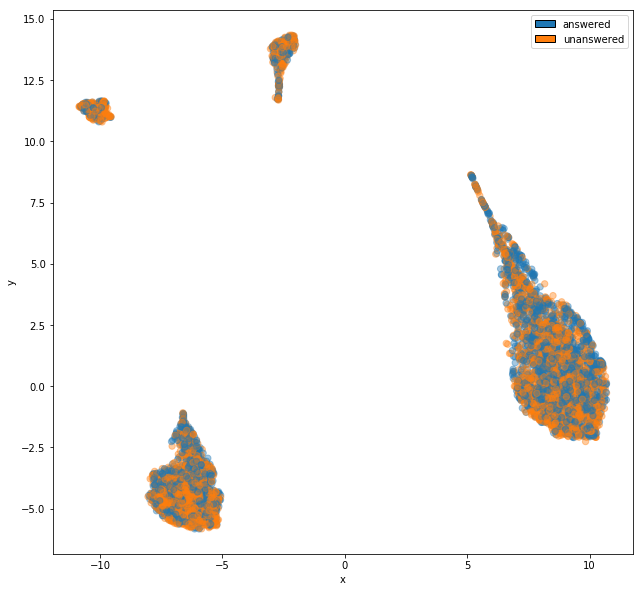

In [11]:
plot_embeddings(umap_features, sent_labels)

We can see that the features seem to have contributed to shaping the landscape of our dataset. In particular, it seems like we've separated some clusters containing a majority of unanswered questions. This is encouraging, and a potential symptom of a feature being helpful. The only way to know for sure, however, is to use it in a model.


Let's go through the dataset once more and see what other features we can come up with. To do so, please uncomment the cell below. It is left commented here simply to speed up the loading of the notebook. Feel free to use the show_question_features_containing function to help you validate hypotheses

In [12]:
# plot_figure = get_interactive_umap_embeddings_plot(umap_features, sent_labels, raw_text, legends=sent_labels)
# show(plot_figure)

One quick additional feature that seemed predictive in my exploration was whether a question was about the english language. Below is a feature that attempts to capture just that

In [13]:
df["language_question"] = (df["body_text"].str.contains("punctuate", regex=False) | df["body_text"].str.contains("capitalize", regex=False) | df["body_text"].str.contains("abbreviate", regex=False)).astype(int)

When looking through the data again, I also discovered that a lot of the relevant information was contained in the title of the question, which we have been ignoring so far. Below is an example of a title describing most of the information 

In [14]:
df[df["body_text"].str.contains("Specifically, how to describe", regex=False)][["body_text", "Title"]]

body_text  \
Id                                                         
23446  Specifically, how to describe a person's voice...   

                                              Title  
Id                                                   
23446  Do you have any tips on describing dialogue?

Let's incorporate the title by concatenating it with the body and then embedding the concatenated version.

In [15]:
df["full_text"] = df["Title"].str.cat(df["body_text"], sep=' ', na_rep='')

We recompute the features described above in the same manner, but using the full text this time. Feel free to see the ml_editor source to see details.

In [16]:
df = add_text_features_to_df(df.loc[df["is_question"]].copy())

In [17]:
train_author, test_author = get_split_by_author(df[df["is_question"]])
train_labels  = train_author["AcceptedAnswerId"].notna()

train_author["vectors"] = train_author["full_text"].apply(lambda x: nlp(x).vector)

In [18]:

vectorized_features = np.append(
        np.vstack(train_author["vectors"]),
        train_author[
            [
                "action_verb_full",
                "question_mark_full",
                "norm_text_len",
                "language_question",
            ]
        ],
        1,
    )

Let's visualize the embeddings once more

In [19]:
umap_embedder = umap.UMAP()
umap_features = umap_embedder.fit_transform(vectorized_features)

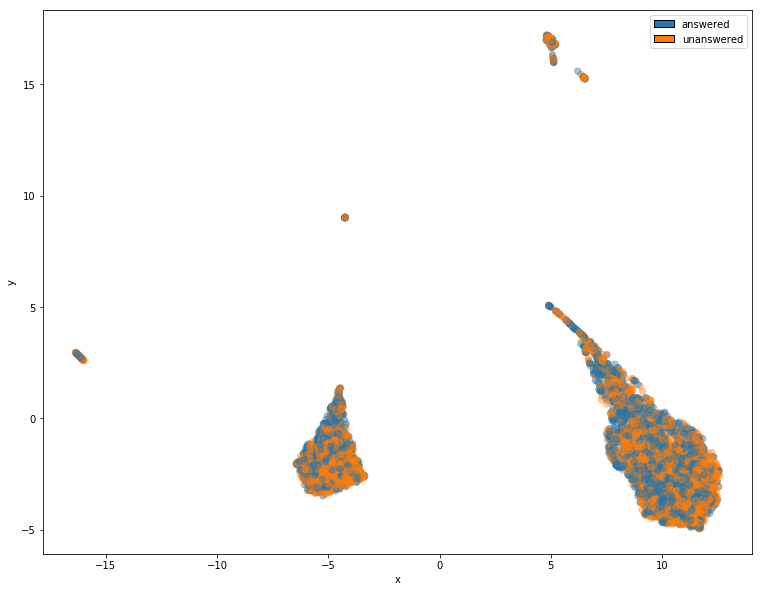

In [20]:
plot_embeddings(umap_features, train_labels)

Above, you can see that we've isolated a few clusters at the top which seem to contain mostly unanswered questions. The features we've added are helping to separate classes, and thus should make the task easier for our model.

To explore the data more, feel free to uncomment the lines below.

In [21]:
# plot_figure = get_interactive_umap_embeddings_plot(umap_features, sent_labels, raw_text, legends=sent_labels)
# show(plot_figure)

We have created an initial set of candidate features that we hope to be predictive.  Now, we can train a model on them, and examine its performance to iterate further!